## Данные:

Данные находятся в двух файлах.  
quant_train.parquet - данные для обучения и валидации  
quant_test.parquet - данные для финальной оценки

Каждый файл - [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) для некоторого актива. Стакан состоит из ценовых уровней и объема заявок на каждом уровне. Глубина стакана - 5.  

Описание колонок:  
midprice - цена актива  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку

## Цель:
Придумать способ в реальном времени (без заглядывания в будущее) принимать решения покупки или продажи актива.   
При создании разметки предполагается использовать ML.   
Важно помнить, что за сделки биржа берет комиссию. Будем считать, что комиссия за сделку = 0.0001 * цену * объем сделки.

### Главные критерии разметки: 
- В каждый момент времени должен быть выбран 1 из 3 видов точек:
> 1. BUY - покупка
> 2. SELL - продажа
> 3. HOLD - ожидание в текущей позе
- Количество сделок каждый день > 20
- Гладкость pnl важнее, чем величина

### Подзадачи:
1. Проанализировать данные
2. Придумать способ сделать разметку на трейн данных
3. Перенести разметку на тестовые данные
4. Посчитать и отрисовать pnl при совершении действий на тесте (сделать простой бектест)

### Критерии оценки: 
- Проведенный анализ данных
- Качество разметки на тесте
- Количество сделок на тесте - чем больше, тем лучше
- Качество бектеста

### Результат:
В качестве результата мы ожидаем пайплайн с анализом данных, созданием разметки и подсчетом результата на тесте. В название файла включите свою фамилию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%%time
train = pd.read_parquet('quant_train.parquet')
test = pd.read_parquet('quant_test.parquet')
# Здесь вместо pandas можно использовать polars(библиотека написана на Rust, которая использует многопоточность, позволяя ускорить обработку в несколько раз)

CPU times: total: 1min 1s
Wall time: 48.1 s


In [4]:
train.shape, test.shape

((7521485, 5), (7361603, 5))

In [27]:
train

,ask_rate,ask_amount,bid_rate,bid_amount,midprice
2019-09-24 00:00:00.483,"[344.18, 344.2, 344.22, 344.23, 344.42]","[4.0, 30.0, 3.41067, 35.5272, 4.12313]","[344.14, 344.12, 344.09, 344.07, 344.0]","[30.0, 9.52911, 6.11866, 38.99999, 8.05609]",344.160
2019-09-24 00:00:00.583,"[344.2, 344.21, 344.22, 344.23, 344.28]","[30.0, 5.5272, 3.41067, 30.0, 9.73999]","[344.12, 344.09, 344.07, 344.05, 344.01]","[9.52911, 6.11866, 38.99999, 2.4, 0.03]",344.160
2019-09-24 00:00:00.683,"[344.2, 344.21, 344.22, 344.23, 344.26]","[30.0, 5.5272, 3.41067, 30.0, 6.5]","[344.15, 344.12, 344.09, 344.07, 344.05]","[10.2285, 9.52911, 12.61866, 38.99999, 2.4]",344.175
2019-09-24 00:00:00.783,"[344.2, 344.21, 344.22, 344.23, 344.26]","[30.0, 5.5272, 3.41067, 30.0, 6.5]","[344.19, 344.16, 344.15, 344.12, 344.09]","[4.0, 494.79014, 10.2285, 9.52911, 6.11866]",344.195
2019-09-24 00:00:00.883,"[344.2, 344.23, 344.24, 344.26, 344.28]","[30.0, 30.0, 3.41067, 6.5, 1.74]","[344.17, 344.16, 344.15, 344.12, 344.09]","[8.774, 494.79014, 2.996, 9.52911, 6.11866]",344.185
...,...,...,...,...,...
2019-10-07 13:04:40.191,"[345.79, 345.8, 345.84, 345.85, 345.86]","[3.14092, 223.59803, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.69]","[1.8198, 2.24415, 3.2053, 3.41067, 14.02963]",345.760
2019-10-07 13:04:40.291,"[345.79, 345.8, 345.84, 345.85, 345.86]","[0.94792, 225.79103, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.69]","[1.8198, 2.24415, 3.2053, 3.41067, 10.62963]",345.760
2019-10-07 13:04:40.391,"[345.79, 345.8, 345.84, 345.85, 345.86]","[0.94792, 225.79103, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.68]","[1.8198, 2.24415, 3.2053, 3.41067, 4.99999]",345.760
2019-10-07 13:04:40.491,"[345.79, 345.8, 345.82, 345.84, 345.85]","[0.94792, 225.79103, 3.41067, 1.44575, 7.23219]","[345.73, 345.72, 345.71, 345.67, 345.66]","[1.8198, 2.24415, 3.2053, 8.61205, 8.68]",345.760


In [28]:
test

,ask_rate,ask_amount,bid_rate,bid_amount,midprice
2019-10-09 09:30:03.365,"[336.42, 336.43, 336.49, 336.54, 336.6]","[3.41067, 19.41908, 8.91917, 12.0, 19.96468]","[336.22, 336.19, 336.17, 336.12, 333.1]","[11.51755, 1.48644, 27.35777, 74.1057, 5.55105]",336.320
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.320
2019-10-09 09:30:03.565,"[336.42, 336.43, 336.49, 336.51, 336.52]","[3.41067, 27.97455, 8.91917, 5.99121, 13.0]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325
2019-10-09 09:30:03.665,"[336.42, 336.43, 336.47, 336.49, 336.51]","[3.41067, 27.97455, 24.91138, 8.91917, 5.99121]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325
2019-10-09 09:30:03.765,"[336.42, 336.43, 336.47, 336.49, 336.5]","[3.41067, 27.97455, 24.91138, 15.1988, 31.96246]","[336.25, 336.23, 336.22, 336.21, 336.17]","[8.98892, 8.67933, 9.11755, 125.39419, 27.35777]",336.335
...,...,...,...,...,...
2019-10-23 20:46:47.121,"[417.52, 417.53, 417.54, 417.56, 417.57]","[1.43033, 2.0366, 1.97911, 4.17178, 8.14]","[417.51, 417.48, 417.47, 417.43, 417.42]","[8.22386, 9.416, 72.0, 2.10745, 2.5958]",417.515
2019-10-23 20:46:47.221,"[417.53, 417.54, 417.56, 417.57, 417.58]","[5.11045, 1.97911, 4.17178, 8.14, 65.51592]","[417.51, 417.47, 417.43, 417.42, 417.41]","[8.22386, 72.0, 2.10745, 2.5958, 0.02522]",417.520
2019-10-23 20:46:47.321,"[417.51, 417.52, 417.54, 417.55, 417.56]","[13.88302, 42.45231, 1.97911, 2.65357, 4.07006]","[417.43, 417.42, 417.41, 417.4, 417.39]","[2.10745, 2.5958, 0.02522, 0.2144, 0.07536]",417.470
2019-10-23 20:46:47.421,"[417.49, 417.51, 417.52, 417.54, 417.55]","[0.12961, 13.88302, 40.41571, 1.97911, 2.53593]","[417.43, 417.42, 417.41, 417.4, 417.39]","[2.10745, 2.5958, 0.02522, 0.2144, 0.07536]",417.460


In [5]:
def extract_features(df):
    #extract bid/ask info and other hft features to estimate momentum
    df['best_ask'] = df.apply(lambda x: min(x['ask_rate']), axis=1)
    df['best_bid'] = df.apply(lambda x: max(x['bid_rate']), axis=1)
    df['best_bid_amount'] = df[['bid_amount']].apply(lambda x: x.str[0])
    df['best_ask_amount'] = df[['ask_amount']].apply(lambda x: x.str[0])
    # depth_ratio = WQa / WQb, WQa = sum(ask_price_i * ask_amount_i), WQb = sum(bid_price_i * bid_amount_i)
    df["WQa"] = df['ask_rate'] * df['ask_amount']
    df["WQb"] = df['bid_rate'] * df['bid_amount']
    df["WQa"] = df.apply(lambda x: sum(x['WQa']), axis=1)
    df["WQb"] = df.apply(lambda x: sum(x['WQb']), axis=1)

    df['depth_ratio'] = df['WQa'] / df['WQb']

    df['spread'] = df['best_ask'] - df['best_bid']
    df['wmid'] = (df['best_ask'] * df['best_bid_amount']) / (df['best_ask'] * df['best_bid_amount'] + df['best_bid'] * df['best_ask_amount'])

    df['imbalance_0'] = (df['best_ask_amount'] - df['best_bid_amount'])/(df['best_ask_amount'] + df['best_bid_amount'])
    df['return'] = df['midprice'] - df['midprice'].shift(1)

    chunks = np.array_split(df, 200)

    for chunk in chunks:
        for i in range(1, 5):
            chunk[f'delta_bid_price_up_{i}'] = chunk[['bid_rate']].apply(lambda x: chunk['best_bid'] - x.str[i])
            # train[f'imbalance_{i}'] = (train['ask_amount'] - train['bid_amount'])/(train['ask_amount'] + train['bid_amount'])
            chunk[f'bid_amount_{i}'] = chunk[['bid_amount']].apply(lambda x: x.str[i])
            chunk[f'ask_amount_{i}'] = chunk[['ask_amount']].apply(lambda x: x.str[i])
            chunk[f'imbalance_{i}'] = (chunk[f'ask_amount_{i}'] - chunk[f'bid_amount_{i}'])/(chunk[f'ask_amount_{i}'] + chunk[f'bid_amount_{i}'])
            chunk.drop(columns=[f'ask_amount_{i}', f'bid_amount_{i}'], inplace=True)
    df = pd.concat(chunks)
    return df

In [6]:
train = extract_features(train)
train

C:\Users\Gregory\PycharmProjects\test_aiptech\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,ask_rate,ask_amount,bid_rate,bid_amount,midprice,best_ask,best_bid,best_bid_amount,best_ask_amount,WQa,...,imbalance_0,return,delta_bid_price_up_1,imbalance_1,delta_bid_price_up_2,imbalance_2,delta_bid_price_up_3,imbalance_3,delta_bid_price_up_4,imbalance_4
2019-09-24 00:00:00.483,"[344.18, 344.2, 344.22, 344.23, 344.42]","[4.0, 30.0, 3.41067, 35.5272, 4.12313]","[344.14, 344.12, 344.09, 344.07, 344.0]","[30.0, 9.52911, 6.11866, 38.99999, 8.05609]",344.160,344.18,344.14,30.00000,4.00000,26526.357318,...,-0.764706,NaN,0.02,0.517869,0.05,-0.284174,0.07,-0.046598,0.14,-0.322924
2019-09-24 00:00:00.583,"[344.2, 344.21, 344.22, 344.23, 344.28]","[30.0, 5.5272, 3.41067, 30.0, 9.73999]","[344.12, 344.09, 344.07, 344.05, 344.01]","[9.52911, 6.11866, 38.99999, 2.4, 0.03]",344.160,344.20,344.12,9.52911,30.00000,27082.722097,...,0.517869,0.000,0.03,-0.050787,0.05,-0.839160,0.07,0.851852,0.11,0.993859
2019-09-24 00:00:00.683,"[344.2, 344.21, 344.22, 344.23, 344.26]","[30.0, 5.5272, 3.41067, 30.0, 6.5]","[344.15, 344.12, 344.09, 344.07, 344.05]","[10.2285, 9.52911, 12.61866, 38.99999, 2.4]",344.175,344.20,344.15,10.22850,30.00000,25967.128339,...,0.491480,0.015,0.03,-0.265796,0.06,-0.574446,0.08,-0.130435,0.10,0.460674
2019-09-24 00:00:00.783,"[344.2, 344.21, 344.22, 344.23, 344.26]","[30.0, 5.5272, 3.41067, 30.0, 6.5]","[344.19, 344.16, 344.15, 344.12, 344.09]","[4.0, 494.79014, 10.2285, 9.52911, 6.11866]",344.195,344.20,344.19,4.00000,30.00000,25967.128339,...,0.764706,0.020,0.03,-0.977905,0.04,-0.499871,0.07,0.517869,0.10,0.030220
2019-09-24 00:00:00.883,"[344.2, 344.23, 344.24, 344.26, 344.28]","[30.0, 30.0, 3.41067, 6.5, 1.74]","[344.17, 344.16, 344.15, 344.12, 344.09]","[8.774, 494.79014, 2.996, 9.52911, 6.11866]",344.185,344.20,344.17,8.77400,30.00000,24663.726241,...,0.547429,-0.010,0.01,-0.885669,0.02,0.064725,0.05,-0.188976,0.08,-0.557176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07 13:04:40.191,"[345.79, 345.8, 345.84, 345.85, 345.86]","[3.14092, 223.59803, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.69]","[1.8198, 2.24415, 3.2053, 3.41067, 14.02963]",345.760,345.79,345.73,1.81980,3.14092,86323.562088,...,0.266316,0.000,0.01,0.980126,0.02,0.204810,0.03,0.359069,0.04,-0.129916
2019-10-07 13:04:40.291,"[345.79, 345.8, 345.84, 345.85, 345.86]","[0.94792, 225.79103, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.69]","[1.8198, 2.24415, 3.2053, 3.41067, 10.62963]",345.760,345.79,345.73,1.81980,0.94792,86323.584018,...,-0.315017,0.000,0.01,0.980318,0.02,0.204810,0.03,0.359069,0.04,0.008108
2019-10-07 13:04:40.391,"[345.79, 345.8, 345.84, 345.85, 345.86]","[0.94792, 225.79103, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.68]","[1.8198, 2.24415, 3.2053, 3.41067, 4.99999]",345.760,345.79,345.73,1.81980,0.94792,86323.584018,...,-0.315017,0.000,0.01,0.980318,0.02,0.204810,0.03,0.359069,0.05,0.367226
2019-10-07 13:04:40.491,"[345.79, 345.8, 345.82, 345.84, 345.85]","[0.94792, 225.79103, 3.41067, 1.44575, 7.23219]","[345.73, 345.72, 345.71, 345.67, 345.66]","[1.8198, 2.24415, 3.2053, 8.61205, 8.68]",345.760,345.79,345.73,1.81980,0.94792,82587.048422,...,-0.315017,0.000,0.01,0.980318,0.02,0.031042,0.06,-0.712512,0.07,-0.090987


> Заметим, что у нас задача классификации. Проведем несколько тестов для разной дельты во времени, т е будем ставить метку BUY SELL HOLD в зависимости от динамики через 100, 200, 500, 1000(1 секунда), 2000(2 секунды), 5000(5 секунд) милисекунд и потом посмотрим на accuracy при разных временных интервалах.

In [7]:
#extract signals
def signals(df):
    intervals = [1,2,5,10,20,50]
    for interval in intervals:
        # HOLD = 0
        df[f'action_{interval}'] = 0
        # BUY = 1
        df.loc[df['midprice'] < df['midprice'].shift(-interval), f'action_{interval}'] = 1
        # SELL = 2
        df.loc[df['midprice'] > df['midprice'].shift(-interval), f'action_{interval}'] = 2

    return df

In [8]:
train = signals(train)
train

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,best_ask,best_bid,best_bid_amount,best_ask_amount,WQa,...,delta_bid_price_up_3,imbalance_3,delta_bid_price_up_4,imbalance_4,action_1,action_2,action_5,action_10,action_20,action_50
2019-09-24 00:00:00.483,"[344.18, 344.2, 344.22, 344.23, 344.42]","[4.0, 30.0, 3.41067, 35.5272, 4.12313]","[344.14, 344.12, 344.09, 344.07, 344.0]","[30.0, 9.52911, 6.11866, 38.99999, 8.05609]",344.160,344.18,344.14,30.00000,4.00000,26526.357318,...,0.07,-0.046598,0.14,-0.322924,0,1,1,1,1,1
2019-09-24 00:00:00.583,"[344.2, 344.21, 344.22, 344.23, 344.28]","[30.0, 5.5272, 3.41067, 30.0, 9.73999]","[344.12, 344.09, 344.07, 344.05, 344.01]","[9.52911, 6.11866, 38.99999, 2.4, 0.03]",344.160,344.20,344.12,9.52911,30.00000,27082.722097,...,0.07,0.851852,0.11,0.993859,1,1,1,1,1,1
2019-09-24 00:00:00.683,"[344.2, 344.21, 344.22, 344.23, 344.26]","[30.0, 5.5272, 3.41067, 30.0, 6.5]","[344.15, 344.12, 344.09, 344.07, 344.05]","[10.2285, 9.52911, 12.61866, 38.99999, 2.4]",344.175,344.20,344.15,10.22850,30.00000,25967.128339,...,0.08,-0.130435,0.10,0.460674,1,1,1,1,1,1
2019-09-24 00:00:00.783,"[344.2, 344.21, 344.22, 344.23, 344.26]","[30.0, 5.5272, 3.41067, 30.0, 6.5]","[344.19, 344.16, 344.15, 344.12, 344.09]","[4.0, 494.79014, 10.2285, 9.52911, 6.11866]",344.195,344.20,344.19,4.00000,30.00000,25967.128339,...,0.07,0.517869,0.10,0.030220,2,1,1,1,2,1
2019-09-24 00:00:00.883,"[344.2, 344.23, 344.24, 344.26, 344.28]","[30.0, 30.0, 3.41067, 6.5, 1.74]","[344.17, 344.16, 344.15, 344.12, 344.09]","[8.774, 494.79014, 2.996, 9.52911, 6.11866]",344.185,344.20,344.17,8.77400,30.00000,24663.726241,...,0.05,-0.188976,0.08,-0.557176,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07 13:04:40.191,"[345.79, 345.8, 345.84, 345.85, 345.86]","[3.14092, 223.59803, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.69]","[1.8198, 2.24415, 3.2053, 3.41067, 14.02963]",345.760,345.79,345.73,1.81980,3.14092,86323.562088,...,0.03,0.359069,0.04,-0.129916,0,0,0,0,0,0
2019-10-07 13:04:40.291,"[345.79, 345.8, 345.84, 345.85, 345.86]","[0.94792, 225.79103, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.69]","[1.8198, 2.24415, 3.2053, 3.41067, 10.62963]",345.760,345.79,345.73,1.81980,0.94792,86323.584018,...,0.03,0.359069,0.04,0.008108,0,0,0,0,0,0
2019-10-07 13:04:40.391,"[345.79, 345.8, 345.84, 345.85, 345.86]","[0.94792, 225.79103, 4.85642, 7.23219, 10.80341]","[345.73, 345.72, 345.71, 345.7, 345.68]","[1.8198, 2.24415, 3.2053, 3.41067, 4.99999]",345.760,345.79,345.73,1.81980,0.94792,86323.584018,...,0.03,0.359069,0.05,0.367226,0,0,0,0,0,0
2019-10-07 13:04:40.491,"[345.79, 345.8, 345.82, 345.84, 345.85]","[0.94792, 225.79103, 3.41067, 1.44575, 7.23219]","[345.73, 345.72, 345.71, 345.67, 345.66]","[1.8198, 2.24415, 3.2053, 8.61205, 8.68]",345.760,345.79,345.73,1.81980,0.94792,82587.048422,...,0.06,-0.712512,0.07,-0.090987,0,0,0,0,0,0


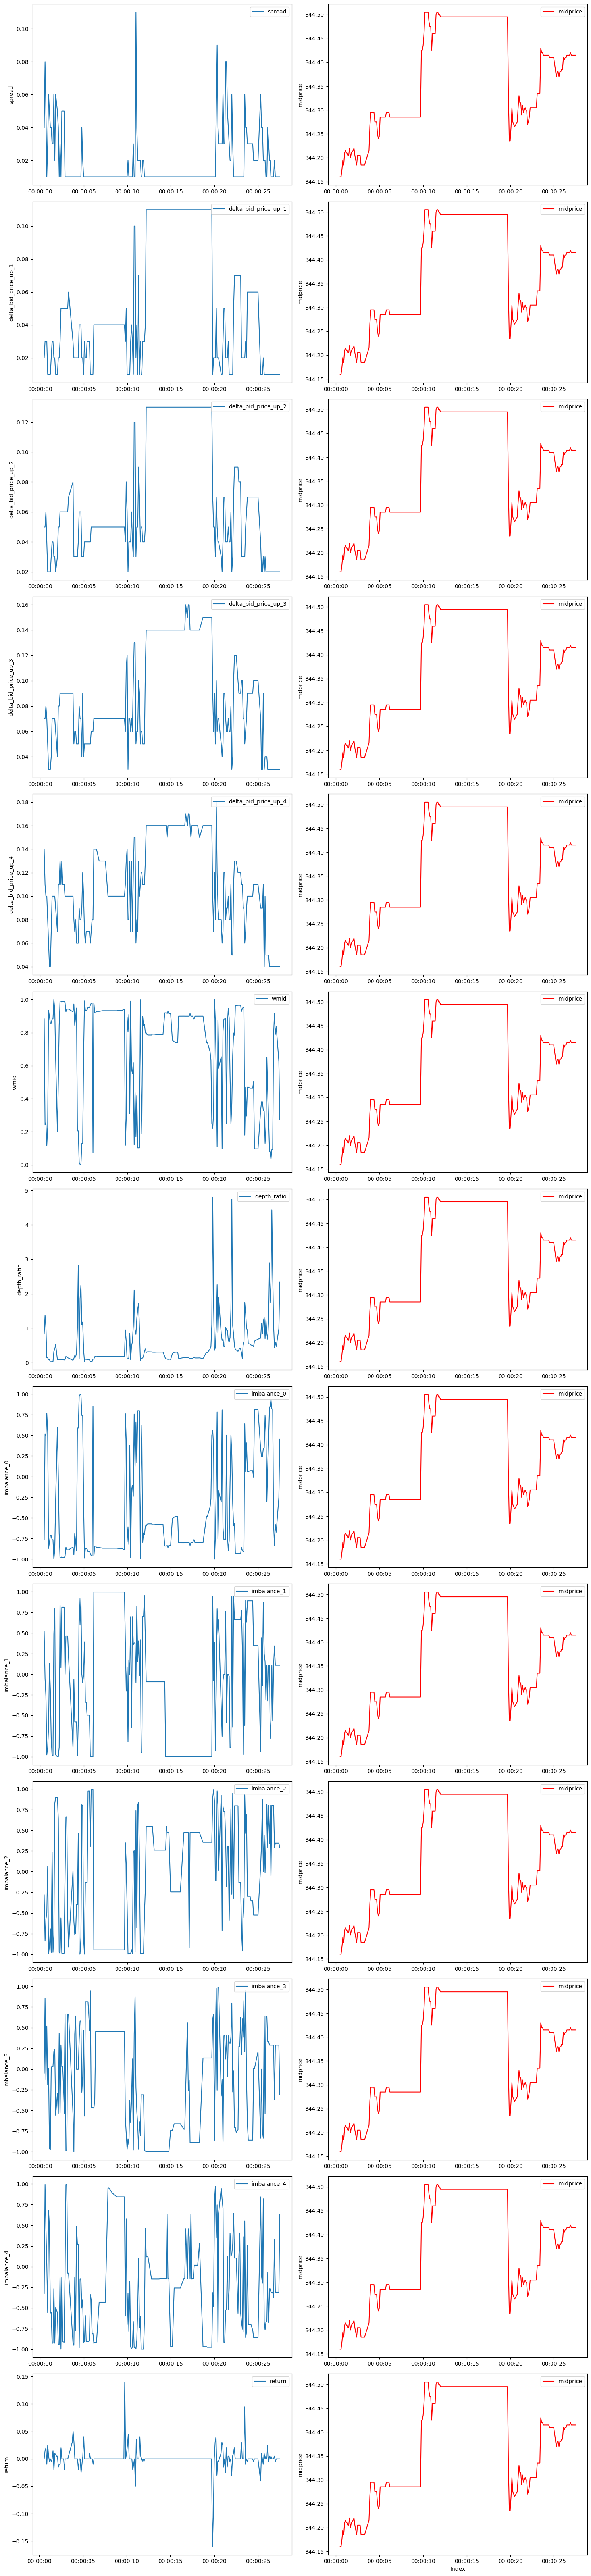

In [28]:
#построим графики по нашим признакам на горизонте секунды
features = ['spread', 'delta_bid_price_up_1', 'delta_bid_price_up_2', 'delta_bid_price_up_3', 'delta_bid_price_up_4', 'wmid', 'depth_ratio', 'imbalance_0', 'imbalance_1', 'imbalance_2', 'imbalance_3', 'imbalance_4', 'return']

subtrain = train.head(200)

fig, axs = plt.subplots(nrows=len(features), ncols=2, figsize=(15, 5 * len(features)))

for i, col in enumerate(subtrain[features]):
    axs[i, 0].plot(subtrain.index, subtrain[col], label=col)
    axs[i, 0].set_ylabel(col)
    axs[i, 0].legend(loc='upper right')

    axs[i, 1].plot(subtrain.index, subtrain['midprice'], label='midprice', color='red')
    axs[i, 1].set_ylabel('midprice')
    axs[i, 1].legend(loc='upper right')

plt.xlabel('Index')
plt.tight_layout()
plt.show()

> Заметим, что дельта между первыми двумя бидами хорошо коррелирует с midprice, также imbalance на первых двух слоях(в итоге другие слои не сильно влияют). Также сделаем отбор признаков с помощью skicit-learn
> Также можно, видеть, что функции кусочно-постоянные, следовательно, заранее можно предположить, что бустинг или случайный лес хорошо будет справляться с предсказанием.
>
> Сравним LightGBM и xgboost


In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

features = ['spread', 'delta_bid_price_up_1', 'delta_bid_price_up_2', 'wmid', 'depth_ratio', 'imbalance_0', 'imbalance_1', 'return']
target = ['action_1']

X_train = train[features]
y_train = train[target]

model = XGBClassifier()
model.fit(X_train, y_train)

# import xgboost as xgb
# import numpy as np
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score
#
# features = ['spread', 'delta_bid_price_up_1', 'delta_bid_price_up_2', 'delta_bid_price_up_3', 'delta_bid_price_up_4', 'wmid', 'depth_ratio', 'imbalance_0', 'imbalance_1', 'imbalance_2', 'imbalance_3', 'imbalance_4', 'return']
# target = ['action_1']
#
# model = xgb.XGBClassifier()
# model.fit(train[features], train[target])
#
# feature_importances = model.feature_importances_
# sorted_indices = np.argsort(feature_importances)[::-1]
# sorted_features = [features[i] for i in sorted_indices]
#
# best_accuracy = 0
# best_feature_subset = []
# for i in range(1, len(features) + 1):
#     subset_features = sorted_features[:i]
#     scores = cross_val_score(xgb.XGBClassifier(), train[subset_features], train[target], cv=5)
#     accuracy = np.mean(scores)
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_feature_subset = subset_features
#
# print("Лучший набор признаков:", best_feature_subset) ->
# features = ['spread', 'delta_bid_price_up_1', 'delta_bid_price_up_2', 'wmid', 'depth_ratio', 'imbalance_0', 'imbalance_1', 'return']
# print("Точность модели с лучшим набором признаков:", best_accuracy)

# from lightgbm import LGBMClassifier
# from sklearn.metrics import accuracy_score
#
# features = ['spread', 'delta_bid_price_up_1', 'delta_bid_price_up_2', 'wmid', 'depth_ratio', 'imbalance_0', 'imbalance_1', 'imbalance_2', 'imbalance_3', 'imbalance_4' 'return']
# target = ['action_1']
#
# X_train = train[features]
# y_train = train[target]
#
# model = LGBMClassifier()
# model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
test = extract_features(test)
test = signals(test)
test

C:\Users\Gregory\PycharmProjects\test_aiptech\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,ask_rate,ask_amount,bid_rate,bid_amount,midprice,best_ask,best_bid,best_bid_amount,best_ask_amount,WQa,...,delta_bid_price_up_3,imbalance_3,delta_bid_price_up_4,imbalance_4,action_1,action_2,action_5,action_10,action_20,action_50
2019-10-09 09:30:03.365,"[336.42, 336.43, 336.49, 336.54, 336.6]","[3.41067, 19.41908, 8.91917, 12.0, 19.96468]","[336.22, 336.19, 336.17, 336.12, 333.1]","[11.51755, 1.48644, 27.35777, 74.1057, 5.55105]",336.320,336.42,336.22,11.51755,3.41067,21440.381487,...,0.10,-0.721273,3.12,0.564892,0,1,1,1,1,2
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.320,336.42,336.22,11.51755,3.41067,19614.689048,...,0.05,-0.640696,0.06,-0.225164,1,1,1,1,1,2
2019-10-09 09:30:03.565,"[336.42, 336.43, 336.49, 336.51, 336.52]","[3.41067, 27.97455, 8.91917, 5.99121, 13.0]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,336.42,336.23,6.27933,3.41067,19950.969048,...,0.06,-0.640696,0.07,-0.186847,0,1,1,1,1,2
2019-10-09 09:30:03.665,"[336.42, 336.43, 336.47, 336.49, 336.51]","[3.41067, 27.97455, 24.91138, 8.91917, 5.99121]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,336.42,336.23,6.27933,3.41067,23958.141077,...,0.06,-0.508273,0.07,-0.520041,1,1,1,1,1,2
2019-10-09 09:30:03.765,"[336.42, 336.43, 336.47, 336.49, 336.5]","[3.41067, 27.97455, 24.91138, 15.1988, 31.96246]","[336.25, 336.23, 336.22, 336.21, 336.17]","[8.98892, 8.67933, 9.11755, 125.39419, 27.35777]",336.335,336.42,336.25,8.98892,3.41067,34810.439489,...,0.04,-0.783790,0.08,0.077624,0,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-23 20:46:47.121,"[417.52, 417.53, 417.54, 417.56, 417.57]","[1.43033, 2.0366, 1.97911, 4.17178, 8.14]","[417.51, 417.48, 417.47, 417.43, 417.42]","[8.22386, 9.416, 72.0, 2.10745, 2.5958]",417.515,417.52,417.51,8.22386,1.43033,7414.878826,...,0.08,0.328755,0.09,0.516422,1,2,0,0,0,0
2019-10-23 20:46:47.221,"[417.53, 417.54, 417.56, 417.57, 417.58]","[5.11045, 1.97911, 4.17178, 8.14, 65.51592]","[417.51, 417.47, 417.43, 417.42, 417.41]","[8.22386, 72.0, 2.10745, 2.5958, 0.02522]",417.520,417.53,417.51,8.22386,5.11045,35459.249908,...,0.09,0.516422,0.10,0.999230,2,2,0,0,0,0
2019-10-23 20:46:47.321,"[417.51, 417.52, 417.54, 417.55, 417.56]","[13.88302, 42.45231, 1.97911, 2.65357, 4.07006]","[417.43, 417.42, 417.41, 417.4, 417.39]","[2.10745, 2.5958, 0.02522, 0.2144, 0.07536]",417.470,417.51,417.43,2.10745,13.88302,27154.838148,...,0.03,0.850487,0.04,0.963642,2,1,0,0,0,0
2019-10-23 20:46:47.421,"[417.49, 417.51, 417.52, 417.54, 417.55]","[0.12961, 13.88302, 40.41571, 1.97911, 2.53593]","[417.43, 417.42, 417.41, 417.4, 417.39]","[2.10745, 2.5958, 0.02522, 0.2144, 0.07536]",417.460,417.49,417.43,2.10745,0.12961,24610.012959,...,0.03,0.804514,0.04,0.942281,1,0,0,0,0,0


In [11]:
X_test = test[features]
y_test = test[target]
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7658304855613648


>Провел тесты для всех action. Accuracy больше всего при action_1 как ни странно и оно приблизительно равное на моделях LightGBM и xgboost
>Отрисуем PnL, сделав небольшой бектест

In [12]:
future_diffs = np.array(test['spread'])
best_bid_amounts = np.array(test['best_bid_amount'])
best_ask_amounts = np.array(test['best_ask_amount'])
curr_prices = np.array(test['midprice'])

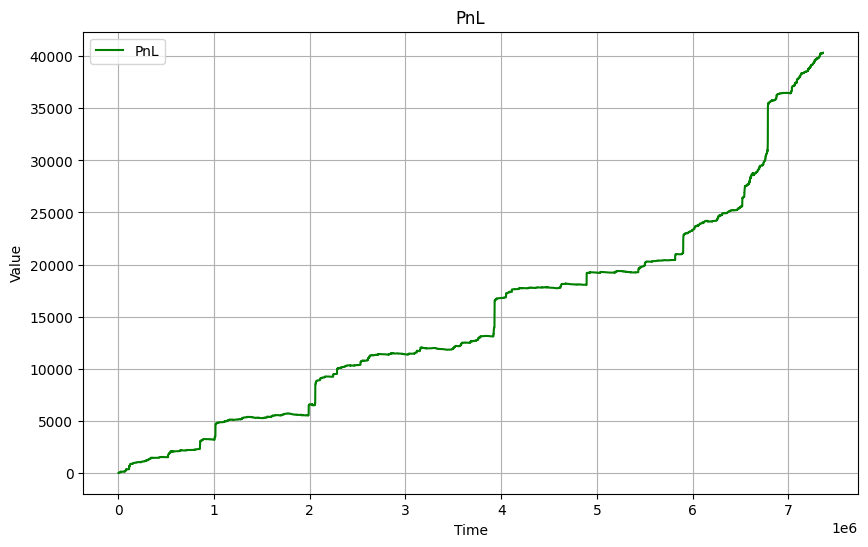

In [14]:
# BUY 1
# SELL 2
# HOLD 0
# Если мы холдим в позиции, а нужно было покупать или продавать, то мы ничего не теряем, поэтому этот случай можно не учитывать
pnl = []

y_test = np.array(y_test)

for i in range(len(y_pred)):
    if y_pred[i] == y_test[i] and y_pred[i] == 1:
        pnl.append(abs(future_diffs[i] * best_ask_amounts[i]) - 0.0001*curr_prices[i]*best_ask_amounts[i])
    elif y_pred[i] == y_test[i] and y_pred[i] == 2:
        pnl.append(abs(future_diffs[i] * best_bid_amounts[i]) - 0.0001*curr_prices[i]*best_bid_amounts[i])
    elif y_pred[i] != y_test[i] and y_pred[i] == 1:
        pnl.append(abs(future_diffs[i] * best_ask_amounts[i]) - 0.0001*curr_prices[i]*best_ask_amounts[i])
    elif y_pred[i] != y_test[i] and y_pred[i] == 2:
        pnl.append(abs(future_diffs[i] * best_bid_amounts[i]) - 0.0001*curr_prices[i]*best_bid_amounts[i])
    else:
        pnl.append(0)

def plot_pnl(pnl):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pnl), label='PnL', color='green')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('PnL')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pnl(pnl)

> Выводы: В то же время стоит отметить что нельзя ориентироваться только на PnL, так как он не учитывает несколько важных факторов. PnL не оценивает уровень риска по перфомансу стратегии, может быть переменчивым и не показывает стабильность перфоманса модели на длинном промежутке. PnL не учитывает просадку в моменте и возврат инвестиций на вложенный капитал.
> Как дополнительные метрики можно использовать Sharpe ratio и Sortino ratio, чтобы учитывать волатильность и calmar ratio и win ratio, чтобы учитывать риск и процент выигрышных сделок

> В продолжении решения можно более аккуратно обработать пропуски во временных данных и добавить другие hft факторы. Также, зная какой конкретно дериватив торгуется учитывать волатильность. Можно также строить эмпирические модели или авторегресионные временные модели, типо GARCH как альтернатива.